# Twitter Airline Sentiment Analysis

## Load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Data Science ITB')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline

## Load data

In [ ]:
# Import twitter data
df = pd.read_csv("/content/drive/My Drive/Data Science ITB/Tweets.csv")

In [ ]:
# Look at first 5 rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Number of rows and columns of data
df.shape

(14640, 15)

In [ ]:
# Count number of missing values in each column
# Note that only missing values in columns we will later drop
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [ ]:
# Only want 2 columns that contains the tweet text and sentiment label
df[['text', 'airline_sentiment']].head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
# Count number of each type of tweet
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
# Convert to integers values
df['airline_sentiment'] = df['airline_sentiment'].replace('neutral', 1)
df['airline_sentiment'] = df['airline_sentiment'].replace('negative', 0)
df['airline_sentiment'] = df['airline_sentiment'].replace('positive', 2)

In [ ]:
# Split into text and label
X = df['text'] # data
y = df['airline_sentiment'] # labels

## Preprocess data

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [ ]:
# Convert training data into tensors to feed into neural net
# create tokenizer
t = Tokenizer()
t.fit_on_texts(X)

In [ ]:
# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1

#15,769 words

In [ ]:
# integer encode everything
sequences = t.texts_to_sequences(X)

In [ ]:
# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [ ]:
tweet_num = max_tweet()
tweet_num

30

The longest tweet has 30 words.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [ ]:
# Convert labels
labels = to_categorical(np.asarray(y))

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.3, random_state = 0)

In [ ]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (10248, 30)
y_train size: (10248, 3)
X_test size: (4392, 30)
y_test size: (4392, 3)


## Pre-trained word embedding

In [ ]:
# load the whole embedding into memory
# 100 dimensional version (embedding dimension)
embeddings_index = dict()
f = open('/content/drive/My Drive/Data Science ITB/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# Because we're using GloVE, need to create a word embedding/word context matrix
# Create a matrix of weights for words in the training set
# One embedding for each word in the training set

# Get all unique words in our training set: Tokenizer index
# Find the corresponding weight vector in GloVe embedding

# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [ ]:
# Create embedding layer using embedding matrix
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],input_length = tweet_num, trainable=False)

## Build Neural Net

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

### Model 1: Simple LSTM Model with regularization, increase dimensionality

In [ ]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 1,943,239
Trainable params: 366,339
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=128)

Epoch 1/20
65/65 [==============================] - 28s 434ms/step - loss: 0.7938 - acc: 0.6587 - val_loss: 0.8564 - val_acc: 0.6146
Epoch 2/20
65/65 [==============================] - 28s 425ms/step - loss: 0.6959 - acc: 0.7194 - val_loss: 0.6625 - val_acc: 0.7449
Epoch 3/20
65/65 [==============================] - 28s 425ms/step - loss: 0.6407 - acc: 0.7423 - val_loss: 0.6084 - val_acc: 0.7576
Epoch 4/20
65/65 [==============================] - 28s 426ms/step - loss: 0.6281 - acc: 0.7452 - val_loss: 0.6980 - val_acc: 0.7468
Epoch 5/20
65/65 [==============================] - 28s 430ms/step - loss: 0.6127 - acc: 0.7498 - val_loss: 0.5808 - val_acc: 0.7644
Epoch 6/20
65/65 [==============================] - 32s 489ms/step - loss: 0.5799 - acc: 0.7676 - val_loss: 0.5605 - val_acc: 0.7771
Epoch 7/20
65/65 [==============================] - 28s 430ms/step - loss: 0.5538 - acc: 0.7742 - val_loss: 0.6508 - val_acc: 0.7498
Epoch 8/20
65/65 [==============================] - 28s 430ms/step - 

In [ ]:
# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8501
Testing Accuracy:  0.7944


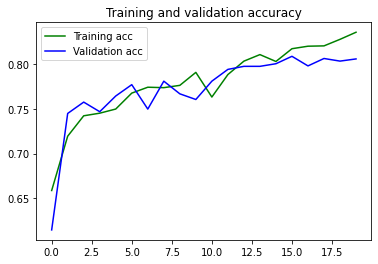

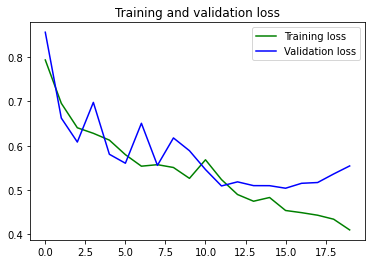

In [ ]:
# Plot train/test loss and accuracy
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
# Get predicted values
y_pred = lstm_mod1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [ ]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [ ]:
class_names = np.array(['Negative', 'Neutral', "Positive"])

Confusion matrix, without normalization
[[2584  134   70]
 [ 400  438   81]
 [ 150   68  467]]
Normalized confusion matrix
[[0.93 0.05 0.03]
 [0.44 0.48 0.09]
 [0.22 0.1  0.68]]


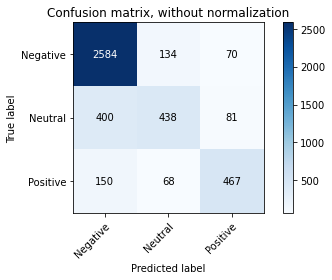

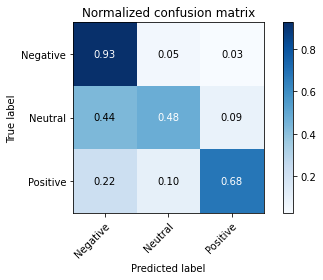

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 2: LSTM with regularization, reduce dimensionality

In [ ]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod2.add(Dense(3, activation='softmax'))
lstm_mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 1,619,335
Trainable params: 42,435
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
hist_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=128)

Epoch 1/20
65/65 [==============================] - 6s 86ms/step - loss: 0.8610 - acc: 0.6189 - val_loss: 0.8141 - val_acc: 0.6488
Epoch 2/20
65/65 [==============================] - 5s 81ms/step - loss: 0.7514 - acc: 0.6914 - val_loss: 0.6654 - val_acc: 0.7341
Epoch 3/20
65/65 [==============================] - 5s 82ms/step - loss: 0.6738 - acc: 0.7216 - val_loss: 0.6314 - val_acc: 0.7459
Epoch 4/20
65/65 [==============================] - 5s 82ms/step - loss: 0.6456 - acc: 0.7390 - val_loss: 0.6294 - val_acc: 0.7580
Epoch 5/20
65/65 [==============================] - 5s 81ms/step - loss: 0.6149 - acc: 0.7568 - val_loss: 0.5893 - val_acc: 0.7605
Epoch 6/20
65/65 [==============================] - 5s 83ms/step - loss: 0.5978 - acc: 0.7618 - val_loss: 0.5681 - val_acc: 0.7722
Epoch 7/20
65/65 [==============================] - 5s 82ms/step - loss: 0.5916 - acc: 0.7586 - val_loss: 0.5977 - val_acc: 0.7663
Epoch 8/20
65/65 [==============================] - 6s 89ms/step - loss: 0.5737 - a

In [ ]:
# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8266
Testing Accuracy:  0.7971


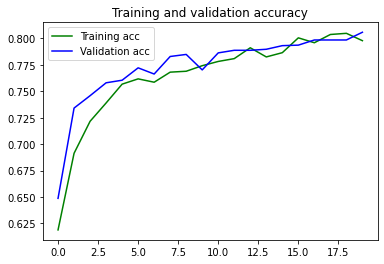

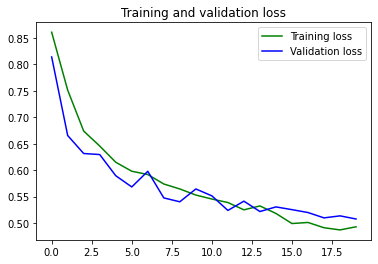

In [ ]:
# Plot train/test loss and accuracy
acc = hist_2.history['acc']
val_acc = hist_2.history['val_acc']
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Get predicted values
y_pred = lstm_mod2.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[2539  170   79]
 [ 365  479   75]
 [ 129   73  483]]
Normalized confusion matrix
[[0.91 0.06 0.03]
 [0.4  0.52 0.08]
 [0.19 0.11 0.71]]


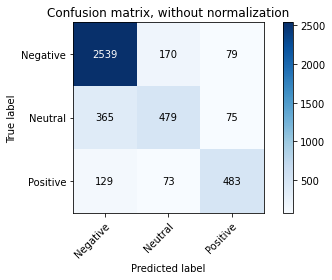

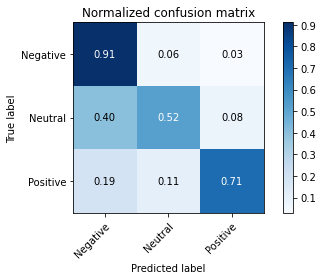

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 3: LSTM Layer Stacking

In [ ]:
# LSTM Model
model_3 = Sequential()
model_3.add(embedding_layer)
model_3.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_3.add(LSTM(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_3.add(Dense(3, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 30, 256)           365568    
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 2,139,975
Trainable params: 563,075
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
history_3 = model_3.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=128)

Epoch 1/20
65/65 [==============================] - 46s 706ms/step - loss: 0.7854 - acc: 0.6702 - val_loss: 0.6962 - val_acc: 0.7176
Epoch 2/20
65/65 [==============================] - 45s 698ms/step - loss: 0.6654 - acc: 0.7297 - val_loss: 0.6311 - val_acc: 0.7400
Epoch 3/20
65/65 [==============================] - 45s 697ms/step - loss: 0.6314 - acc: 0.7429 - val_loss: 0.7216 - val_acc: 0.6854
Epoch 4/20
65/65 [==============================] - 45s 698ms/step - loss: 0.6380 - acc: 0.7405 - val_loss: 0.5898 - val_acc: 0.7683
Epoch 5/20
65/65 [==============================] - 45s 694ms/step - loss: 0.5908 - acc: 0.7582 - val_loss: 0.5773 - val_acc: 0.7649
Epoch 6/20
65/65 [==============================] - 45s 694ms/step - loss: 0.5827 - acc: 0.7602 - val_loss: 0.5698 - val_acc: 0.7766
Epoch 7/20
65/65 [==============================] - 45s 692ms/step - loss: 0.5693 - acc: 0.7701 - val_loss: 0.5723 - val_acc: 0.7668
Epoch 8/20
65/65 [==============================] - 45s 691ms/step - 

In [ ]:
# Find train and test accuracy
loss, accuracy = model_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8568
Testing Accuracy:  0.7794


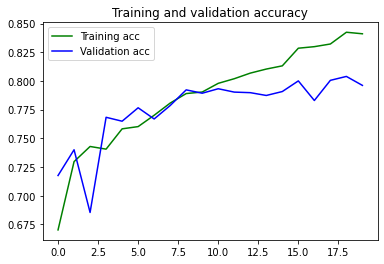

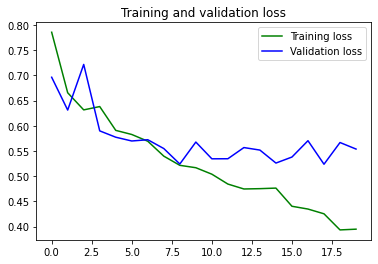

In [ ]:
# Plot train/test loss and accuracy
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Get predicted values
y_pred = model_3.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[2519  228   41]
 [ 350  509   60]
 [ 194   96  395]]
Normalized confusion matrix
[[0.9  0.08 0.01]
 [0.38 0.55 0.07]
 [0.28 0.14 0.58]]


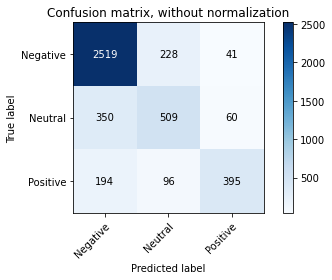

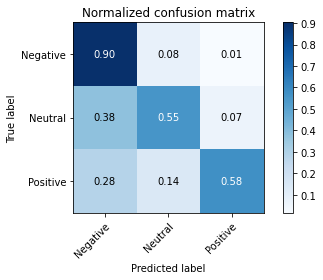

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 4: GRU Layer Stacking

In [ ]:
# GRU Model 2: reduce number of epochs
model_4 = Sequential()
model_4.add(embedding_layer)
model_4.add(GRU(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_4.add(GRU(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_4.add(Dense(3, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 256)           274944    
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,000,455
Trainable params: 423,555
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
history_4 = model_4.fit(X_train, y_train, validation_split = 0.2, epochs=20, batch_size=128)

Epoch 1/20
65/65 [==============================] - 39s 599ms/step - loss: 0.8320 - acc: 0.6467 - val_loss: 1.1292 - val_acc: 0.5117
Epoch 2/20
65/65 [==============================] - 38s 590ms/step - loss: 0.7713 - acc: 0.6727 - val_loss: 0.6809 - val_acc: 0.7161
Epoch 3/20
65/65 [==============================] - 39s 593ms/step - loss: 0.6837 - acc: 0.7110 - val_loss: 0.6346 - val_acc: 0.7439
Epoch 4/20
65/65 [==============================] - 38s 590ms/step - loss: 0.6295 - acc: 0.7432 - val_loss: 0.7488 - val_acc: 0.6634
Epoch 5/20
65/65 [==============================] - 38s 588ms/step - loss: 0.6151 - acc: 0.7466 - val_loss: 0.5729 - val_acc: 0.7712
Epoch 6/20
65/65 [==============================] - 38s 591ms/step - loss: 0.5738 - acc: 0.7699 - val_loss: 0.5379 - val_acc: 0.7863
Epoch 7/20
65/65 [==============================] - 38s 591ms/step - loss: 0.5547 - acc: 0.7743 - val_loss: 0.5589 - val_acc: 0.7732
Epoch 8/20
65/65 [==============================] - 39s 593ms/step - 

In [ ]:
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8617
Testing Accuracy:  0.7976


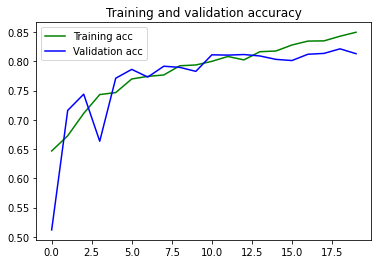

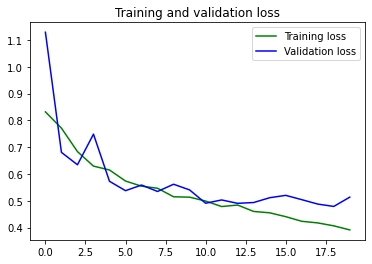

In [ ]:
acc = history_4.history['acc']
val_acc = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Get predicted values
y_pred = model_4.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[2573  146   69]
 [ 361  443  115]
 [ 150   48  487]]
Normalized confusion matrix
[[0.92 0.05 0.02]
 [0.39 0.48 0.13]
 [0.22 0.07 0.71]]


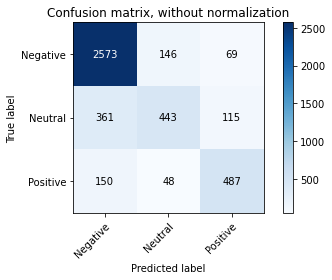

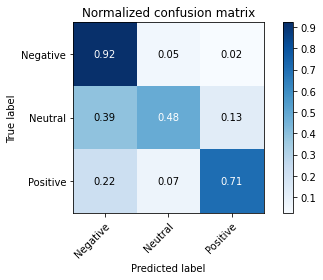

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 5: GRU Layer Stacking remove dimension

In [ ]:
# GRU Model 2: reduce number of epochs
model_5 = Sequential()
model_5.add(embedding_layer)
model_5.add(GRU(128, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_5.add(GRU(64,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_5.add(Dense(3, activation='softmax'))
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
gru_4 (GRU)                  (None, 30, 128)           88320     
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 1,702,663
Trainable params: 125,763
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
history_5 = model_5.fit(X_train, y_train, validation_split = 0.2, epochs=20, batch_size=128)

Epoch 1/20
65/65 [==============================] - 15s 231ms/step - loss: 0.8595 - acc: 0.6326 - val_loss: 0.7721 - val_acc: 0.6810
Epoch 2/20
65/65 [==============================] - 15s 226ms/step - loss: 0.7314 - acc: 0.6929 - val_loss: 0.7563 - val_acc: 0.6654
Epoch 3/20
65/65 [==============================] - 15s 235ms/step - loss: 0.6863 - acc: 0.7179 - val_loss: 0.6629 - val_acc: 0.7410
Epoch 4/20
65/65 [==============================] - 14s 220ms/step - loss: 0.6380 - acc: 0.7419 - val_loss: 0.6269 - val_acc: 0.7522
Epoch 5/20
65/65 [==============================] - 14s 222ms/step - loss: 0.5953 - acc: 0.7629 - val_loss: 0.5531 - val_acc: 0.7815
Epoch 6/20
65/65 [==============================] - 14s 222ms/step - loss: 0.5726 - acc: 0.7653 - val_loss: 0.5444 - val_acc: 0.7844
Epoch 7/20
65/65 [==============================] - 14s 223ms/step - loss: 0.5667 - acc: 0.7691 - val_loss: 0.5402 - val_acc: 0.7839
Epoch 8/20
65/65 [==============================] - 14s 222ms/step - 

In [ ]:
loss, accuracy = model_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8521
Testing Accuracy:  0.7980


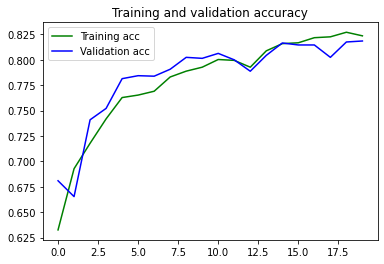

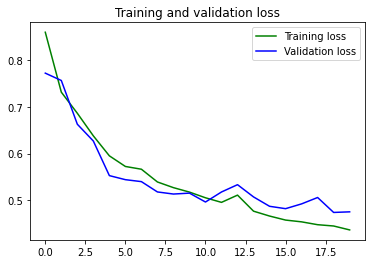

In [ ]:
acc = history_5.history['acc']
val_acc = history_5.history['val_acc']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Get predicted values
y_pred = model_5.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[2546  164   78]
 [ 359  478   82]
 [ 124   80  481]]
Normalized confusion matrix
[[0.91 0.06 0.03]
 [0.39 0.52 0.09]
 [0.18 0.12 0.7 ]]


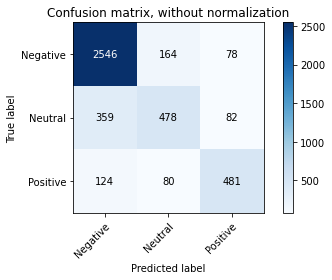

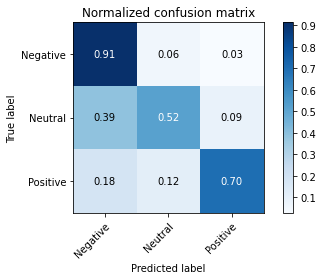

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## References

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html<br>
https://realpython.com/python-keras-text-classification/<br>
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/<br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

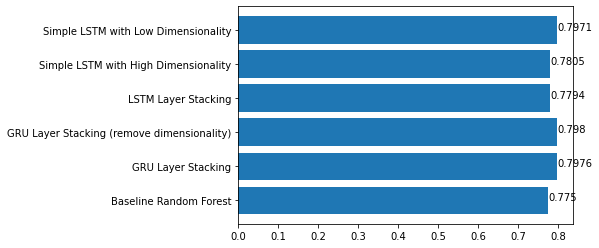

In [ ]:
x = ["Simple LSTM with High Dimensionality", "Simple LSTM with Low Dimensionality", "LSTM Layer Stacking", "GRU Layer Stacking", "GRU Layer Stacking (remove dimensionality)", "Baseline Random Forest"]
y = [0.7805, 0.7971, 0.7794, 0.7976, 0.7980, 0.775]

x, y = zip(*sorted(zip(x,y), reverse=False))
plt.barh(x, y)

for index, value in enumerate(y):
    plt.text(value, index, str(value))